In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
import seaborn as sns
import tiffile as tiff
import glob
import re
import random
import itertools
import anndata as ad
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import scipy
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings('default')
from sklearn.model_selection import KFold
import os

random.seed(0)
np.random.seed(0)

In [2]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

In [3]:
# load the anndata file with the SIFT descriptors
adata = ad.read_h5ad('/gladstone/engelhardt/lab/adamw/saft_figuren/analysis/adata_20250225_kmeans.h5ad')
adata

/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 3389740 × 128
    obs: 'donor_id', 'time', 'well_id', 'rasa2ko_titration', 'et_ratio', 'entropy', 'p_areas', 'filename', 'scales', 'octaves', 'sigmas', 'orientations', 'x', 'y', 'n_og_keypoints', 'kmeans_3', 'kmeans_4', 'kmeans_5', 'kmeans_6', 'kmeans_7', 'kmeans_8', 'kmeans_9', 'kmeans_10'
    uns: 'kmeans_10', 'kmeans_3', 'kmeans_4', 'kmeans_5', 'kmeans_6', 'kmeans_7', 'kmeans_8', 'kmeans_9'
    obsm: 'X_pca'

In [4]:
# move PC1 and PC2 from adata.obsm['X_pca'] to adata.obs['PC1'] and adata.obs['PC2']
adata.obs['PC1'] = adata.obsm['X_pca'][:, 0]
adata.obs['PC2'] = adata.obsm['X_pca'][:, 1]

In [5]:
# compute a replicate_id integer based on the well_id
# if the well_id ends in an odd number, then the replicate_id is 1
# if the well_id ends in an even number, then the replicate_id is 0
adata.obs['replicate_id'] = adata.obs['well_id'].apply(lambda x: int(x[-1]) % 2)

In [6]:
adata.obs.head()

,donor_id,time,well_id,rasa2ko_titration,et_ratio,entropy,p_areas,filename,scales,octaves,...,kmeans_4,kmeans_5,kmeans_6,kmeans_7,kmeans_8,kmeans_9,kmeans_10,PC1,PC2,replicate_id
732,1,0,B2,100.0,2.8284,4.017321,27030,/gladstone/engelhardt/lab/MarsonLabIncucyteDat...,2,0,...,1,0,4,5,6,3,8,-0.740400,5.159865,0
21,1,0,B2,100.0,2.8284,4.017321,27030,/gladstone/engelhardt/lab/MarsonLabIncucyteDat...,1,0,...,0,4,3,3,5,4,2,8.601038,-4.961225,0
628,1,0,B2,100.0,2.8284,4.017321,27030,/gladstone/engelhardt/lab/MarsonLabIncucyteDat...,1,0,...,1,0,4,0,2,1,3,3.662782,3.339856,0
953,1,0,B2,100.0,2.8284,4.017321,27030,/gladstone/engelhardt/lab/MarsonLabIncucyteDat...,2,0,...,3,3,0,2,1,2,6,7.728697,2.313755,0
785,1,0,B2,100.0,2.8284,4.017321,27030,/gladstone/engelhardt/lab/MarsonLabIncucyteDat...,1,0,...,2,2,2,4,3,0,5,-3.843816,0.408007,0


In [7]:
adata.obs.columns

Index(['donor_id', 'time', 'well_id', 'rasa2ko_titration', 'et_ratio',
       'entropy', 'p_areas', 'filename', 'scales', 'octaves', 'sigmas',
       'orientations', 'x', 'y', 'n_og_keypoints', 'kmeans_3', 'kmeans_4',
       'kmeans_5', 'kmeans_6', 'kmeans_7', 'kmeans_8', 'kmeans_9', 'kmeans_10',
       'PC1', 'PC2', 'replicate_id'],
      dtype='object')

In [8]:
entropy_df = adata.obs[['donor_id', 'time', 'well_id', 'replicate_id','rasa2ko_titration', 'et_ratio', 'entropy', 'p_areas', 'n_og_keypoints']].drop_duplicates()
entropy_df

,donor_id,time,well_id,replicate_id,rasa2ko_titration,et_ratio,entropy,p_areas,n_og_keypoints
732,1,0,B2,0,100.0,2.8284,4.017321,27030,1180
1138,1,1,B2,0,100.0,2.8284,4.027862,29369,1260
581,1,2,B2,0,100.0,2.8284,4.067004,32200,1288
841,1,3,B2,0,100.0,2.8284,4.056367,34059,1191
1108,1,4,B2,0,100.0,2.8284,4.041520,35560,1166
...,...,...,...,...,...,...,...,...,...
2337,4,63,J11,1,6.3,0.7071,4.401764,321211,4256
3785,4,64,J11,1,6.3,0.7071,4.400995,320675,4231
2054,4,65,J11,1,6.3,0.7071,4.401333,317018,4385
452,4,66,J11,1,6.3,0.7071,4.402876,320898,4273


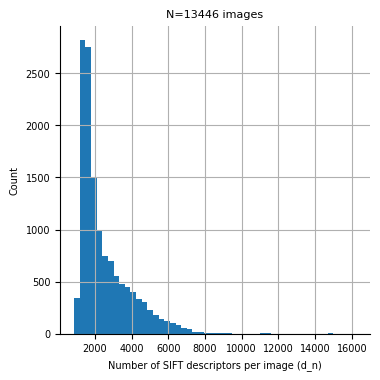

In [37]:
# plot a histogram of the number of keypoints per image
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
entropy_df['n_og_keypoints'].hist(bins=50, ax=ax)
ax.set_xlabel('Number of SIFT descriptors per image (d_n)')
ax.set_ylabel('Count')
ax.set_title('N={} images'.format(len(entropy_df)))
sns.despine(ax=ax)
plt.show()

/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


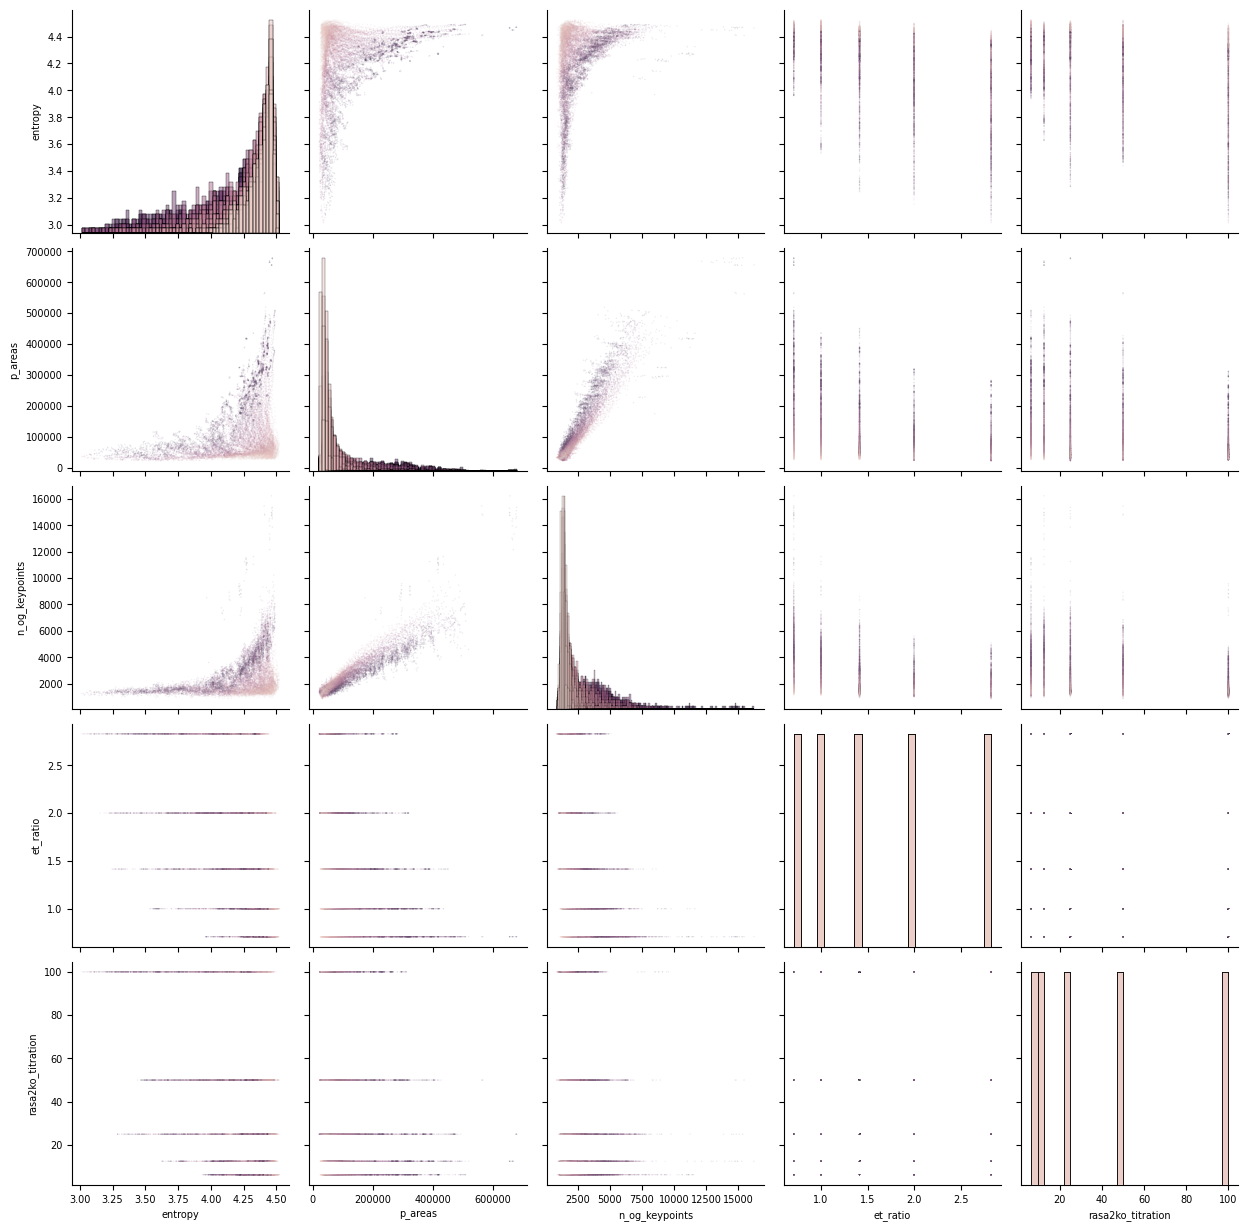

In [10]:
g = sns.PairGrid(entropy_df[['entropy', 'p_areas', 'n_og_keypoints', 'et_ratio', 'rasa2ko_titration', 'time']], diag_sharey=False, hue='time')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot, s=1, alpha=0.1)
plt.show()

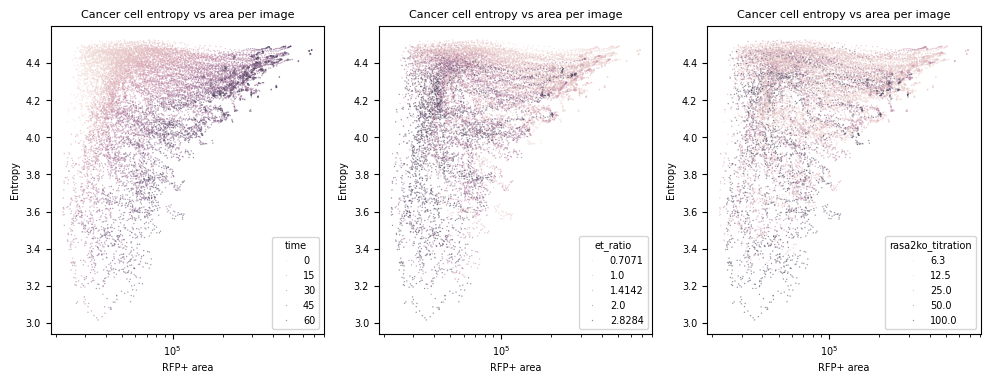

In [11]:
# plot a scatterplot of entropy vs p_areas with the hue being time
# alongside the same scatterplot with the hue being et_ratio
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax = ax.flatten()
sns.scatterplot(ax=ax[0], data=entropy_df, x='p_areas', y='entropy', hue='time', s=1, alpha=0.5)
sns.scatterplot(ax=ax[1], data=entropy_df, x='p_areas', y='entropy', hue='et_ratio', s=1, alpha=0.5)
sns.scatterplot(ax=ax[2], data=entropy_df, x='p_areas', y='entropy', hue='rasa2ko_titration', s=1, alpha=0.5)

for i in range(3):
    ax[i].set_xlabel('RFP+ area')
    ax[i].set_ylabel('Entropy')
    ax[i].set_title('Cancer cell entropy vs area per image')
    # log scale the x axis
    ax[i].set_xscale('log')

plt.show()

## Look at the entropy values over time for different RASA2KO titrations and E:T ratios

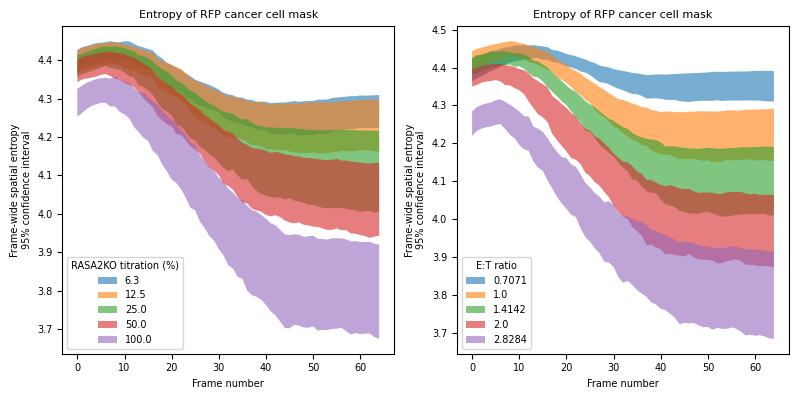

In [12]:


def histogram_intersection(hist1, hist2):
    return np.sum(np.minimum(hist1, hist2))
    
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def plot_entropy_vs_time_confidence_interval(entropy_df, column, ax=None,confidence=0.95, max_time=np.inf):
    
    if ax is None:
        fig, ax = plt.subplots()
    
    for value, df in entropy_df.groupby(column):
        # find the unique times, sort them, and take only the times that are less than max_time
        unique_times = df['time'].unique()
        unique_times = np.sort(unique_times)
        unique_times = unique_times[unique_times <= max_time]

        # placeholder for the mean, lower bound, and upper bound
        interval_holder0 = []

        for t in unique_times:
            # find the mean and the confidence interval for each time
            temp_df = df[df['time'] == t]
            mean0, blb0, bub0 = mean_confidence_interval(temp_df['entropy'], confidence=confidence)
            interval0 = [mean0, blb0, bub0]
            interval_holder0.append(interval0)

        # convert the placeholder to an array
        interval_holder0 = np.array(interval_holder0)

        # plot the confidence interval
        ax.fill_between(unique_times, interval_holder0[:,1], interval_holder0[:,2], alpha=0.6, label=value)

    ax.set_title("Entropy of RFP cancer cell mask")
    ax.set_ylabel("Frame-wide spatial entropy\n95% confidence interval")
    ax.set_xlabel("Frame number")
    ax.legend(title=column)

fig, ax = plt.subplots(1, 2, figsize=(8,4), tight_layout=True)
ax = ax.flatten()
plot_entropy_vs_time_confidence_interval(entropy_df, 'rasa2ko_titration', ax=ax[0], confidence=0.95, max_time=64)
plot_entropy_vs_time_confidence_interval(entropy_df, 'et_ratio', ax=ax[1], confidence=0.95, max_time=64)
ax[0].legend(title='RASA2KO titration (%)', loc='lower left')
ax[1].legend(title='E:T ratio', loc='lower left')


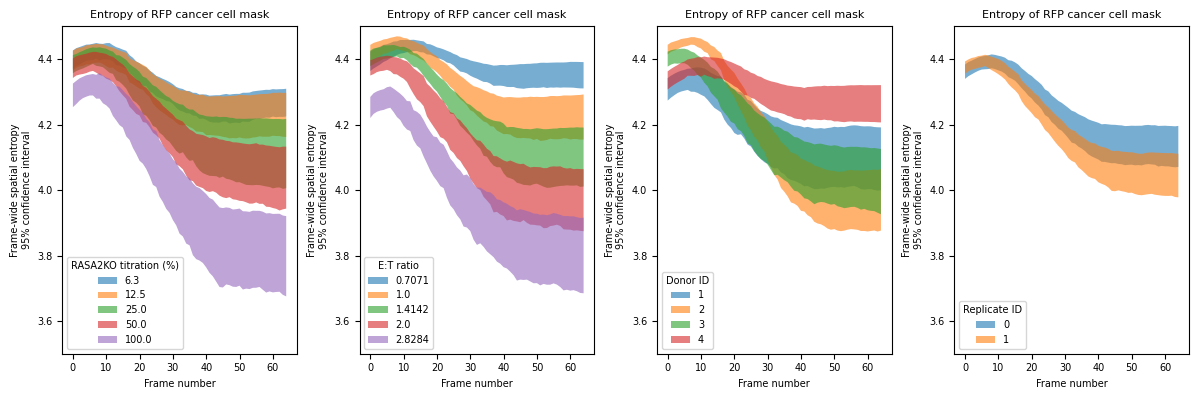

In [13]:
fig, ax = plt.subplots(1, 4, figsize=(12,4), tight_layout=True)
ax = ax.flatten()

plot_entropy_vs_time_confidence_interval(entropy_df, 'rasa2ko_titration', ax=ax[0], confidence=0.95, max_time=64)
plot_entropy_vs_time_confidence_interval(entropy_df, 'et_ratio', ax=ax[1], confidence=0.95, max_time=64)
ax[0].legend(title='RASA2KO titration (%)', loc='lower left')
ax[1].legend(title='E:T ratio', loc='lower left')

plot_entropy_vs_time_confidence_interval(entropy_df, 'donor_id', ax=ax[2], confidence=0.95, max_time=64)
plot_entropy_vs_time_confidence_interval(entropy_df, 'replicate_id', ax=ax[3], confidence=0.95, max_time=64)
ax[2].legend(title='Donor ID', loc='lower left')
ax[3].legend(title='Replicate ID', loc='lower left')

# set the y-axis limits to be the same for all subplots
for i in range(4):
    ax[i].set_ylim(3.5, 4.5)

plt.show()

In [14]:
red_path = adata.obs['filename'][0].replace('phase_registered', 'red_registered')

resized_latish_red = tiff.imread(red_path)
# threshold the red channel into a binary mask
aggregate_threshed = resized_latish_red > 3.5

# check if red_path file exists
if not os.path.exists(red_path):
    print('File does not exist: {}'.format(red_path))
else:
    print('File exists: {}'.format(red_path))

File exists: /gladstone/engelhardt/lab/MarsonLabIncucyteData/AnalysisFiles/4DonorAssay/registered_images/Donor1/red_registered/B2_reg_0000.tif


/tmp/ipykernel_2131525/2920828722.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  red_path = adata.obs['filename'][0].replace('phase_registered', 'red_registered')


In [15]:
entropy_df[(entropy_df['rasa2ko_titration'] == 100) & (entropy_df['et_ratio'] == 2.8284) & (entropy_df['replicate_id'] == 0)]['well_id'].unique()[0]

'B2'

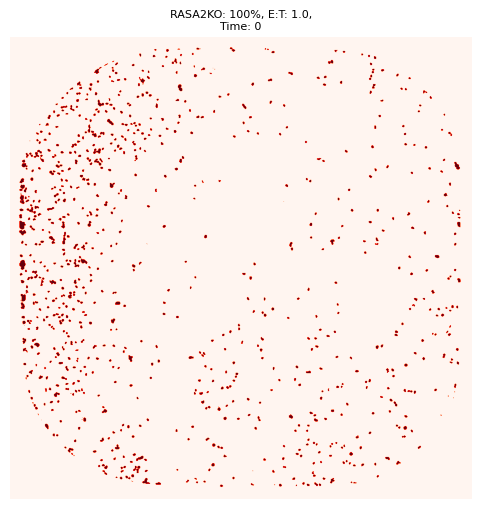

In [16]:
def sorted_nicely( l ): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)


def plot_representative_fn(metadata_df, rasa_value, et_value, replicate_id, donor_id, time_point, trim=100, lab_folder_path='/gladstone/engelhardt/lab/', ax=None, phase=True):
    '''
    Given a rasa value, et value, replicate id, donor id, and time point, plot the representative bright field + RFP image. 
    The mapping of rasa_value, et_value, and replicate_id to well_id is done using metadata_df which is a DataFrame with columns 'rasa2ko_titration', 'et_ratio', 'replicate_id', and 'well_id'.
    Overlay the RFP mask onto the bright field image if phase=True.
    '''
    # create a list of all the image file paths that correspond to this donor_id
    donor_location_phase = lab_folder_path + "MarsonLabIncucyteData/AnalysisFiles/4DonorAssay/registered_images/Donor{}/phase_registered/*tif".format(donor_id)
    donor_location_red = lab_folder_path + "MarsonLabIncucyteData/AnalysisFiles/4DonorAssay/registered_images/Donor{}/red_registered/*tif".format(donor_id)
    files_phase = glob.glob(donor_location_phase)
    files_red = glob.glob(donor_location_red)

    # find the well id that corresponds to the specified rasa_value, et_value, and replicate_id
    well_id = metadata_df[(metadata_df['rasa2ko_titration'] == rasa_value) & (metadata_df['et_ratio'] == et_value) & (metadata_df['replicate_id'] == replicate_id)]['well_id'].unique()[0]

    # find the list of file paths that correspond to the specified well_id
    # store all image paths from this well in a list, sorted by timepoint
    #phase
    matching = [s for s in files_phase if (well_id + "_") in s]
    sorted_file_list_phase = (sorted_nicely(matching))
    # #red
    matching = [s for s in files_red if (well_id + "_") in s]
    sorted_file_list_red = (sorted_nicely(matching))

    # subset the list to the specified time point and load the images
    resized_latish_phase = tiff.imread(sorted_file_list_phase[time_point])
    resized_latish_red = tiff.imread(sorted_file_list_red[time_point])
    # threshold the red channel into a binary mask
    red_frame = resized_latish_red > 3.5

    # normalize intensity of the phase image
    phase_frame = cv.normalize(resized_latish_phase, None, 0, 255, cv.NORM_MINMAX).astype('uint8') 

    # plot the phase image with the red mask superimposed
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6,6))

    trim=100
    ax.imshow(red_frame[trim:-trim,trim:-trim], cmap='Reds', alpha = 1.0)
    if phase:
        ax.imshow(phase_frame[trim:-trim,trim:-trim], cmap='gray', alpha = .75)
    ax.set_title('RASA2KO: {}%, E:T: {},\nTime: {}'.format(round(rasa_value,1),round(et_value,2),time_point))
    # remove the axes ticks and labels
    ax.set_axis_off()
    
    return


plot_representative_fn(entropy_df, rasa_value=100, et_value=1.0, replicate_id=0, donor_id=1, time_point=0, trim=100, phase=False)


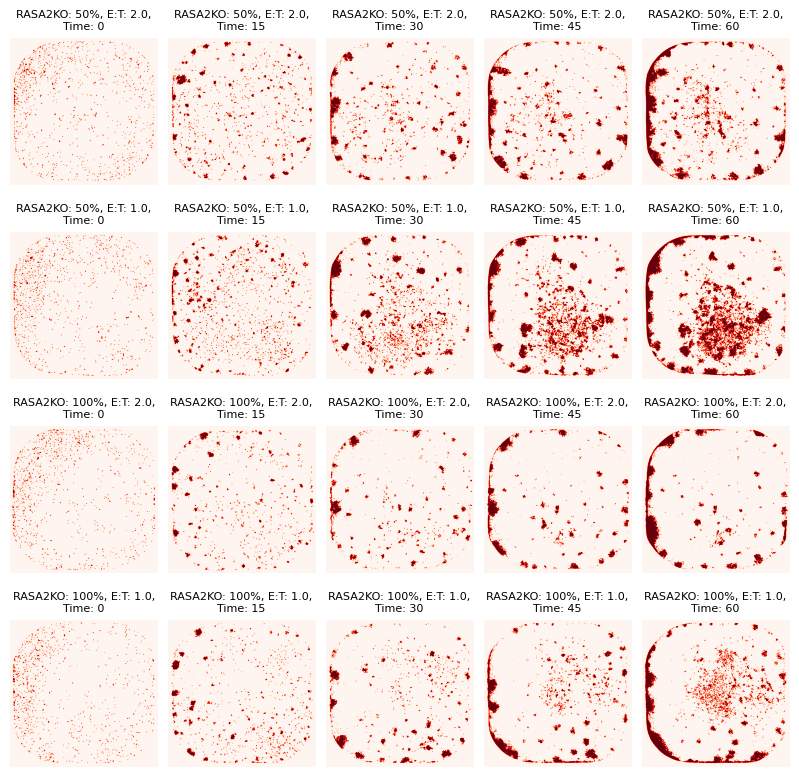

In [17]:
fig, ax = plt.subplots(4, 5, figsize=(8,8), tight_layout=True)

# find 5 evenly spaced time points between 0 and 64
times = [0, 15, 30, 45, 60]
# donor ID is always 1 and replicate ID is always 0
donor_id = 1
replicate_id = 0
phase=False

# top row of subplots have rasa_value=50, et_value=2.0
for i in range(5):
    plot_representative_fn(entropy_df, rasa_value=50, et_value=2.0, replicate_id=replicate_id, donor_id=donor_id, time_point=times[i], trim=100, ax=ax[0,i], phase=phase)

# second row of subplots have rasa_value=50, et_value=1.0
for i in range(5):
    plot_representative_fn(entropy_df, rasa_value=50, et_value=1.0, replicate_id=replicate_id, donor_id=donor_id, time_point=times[i], trim=100, ax=ax[1,i], phase=phase)

# third row of subplots have rasa_value=100, et_value=2.0
for i in range(5):
    plot_representative_fn(entropy_df, rasa_value=100, et_value=2.0, replicate_id=replicate_id, donor_id=donor_id, time_point=times[i], trim=100, ax=ax[2,i], phase=phase)

# fourth row of subplots have rasa_value=100, et_value=1.0
for i in range(5):
    plot_representative_fn(entropy_df, rasa_value=100, et_value=1.0, replicate_id=replicate_id, donor_id=donor_id, time_point=times[i], trim=100, ax=ax[3,i], phase=phase)

plt.show()

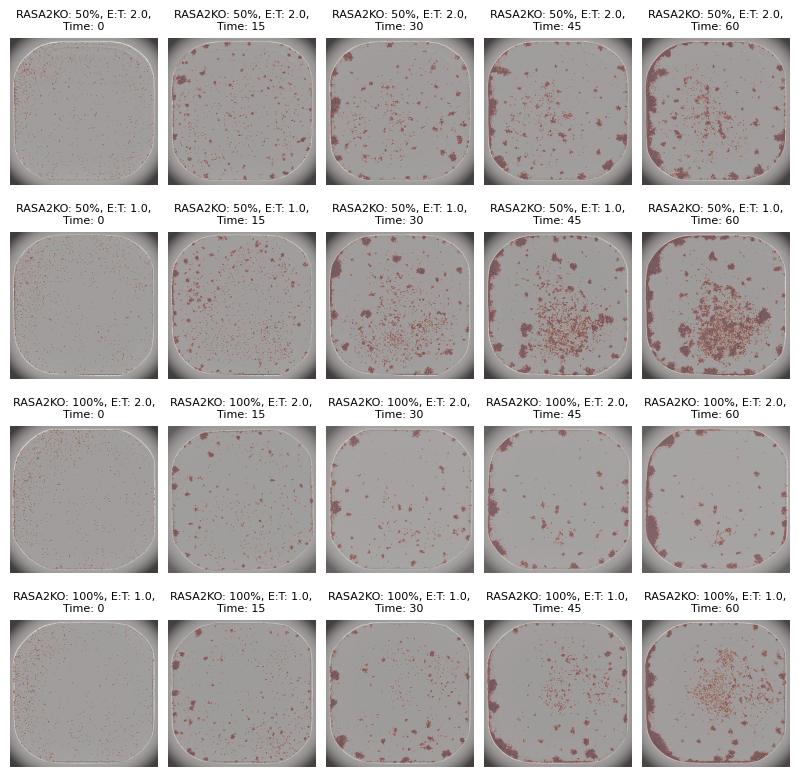

In [18]:
# repeat the above plot showing both phase and red channel
fig, ax = plt.subplots(4, 5, figsize=(8,8), tight_layout=True)

# find 5 evenly spaced time points between 0 and 64
times = [0, 15, 30, 45, 60]
# donor ID is always 1 and replicate ID is always 0
donor_id = 1
replicate_id = 0
phase=True

# top row of subplots have rasa_value=50, et_value=2.0
for i in range(5):
    plot_representative_fn(entropy_df, rasa_value=50, et_value=2.0, replicate_id=replicate_id, donor_id=donor_id, time_point=times[i], trim=100, ax=ax[0,i], phase=phase)

# second row of subplots have rasa_value=50, et_value=1.0
for i in range(5):
    plot_representative_fn(entropy_df, rasa_value=50, et_value=1.0, replicate_id=replicate_id, donor_id=donor_id, time_point=times[i], trim=100, ax=ax[1,i], phase=phase)

# third row of subplots have rasa_value=100, et_value=2.0
for i in range(5):
    plot_representative_fn(entropy_df, rasa_value=100, et_value=2.0, replicate_id=replicate_id, donor_id=donor_id, time_point=times[i], trim=100, ax=ax[2,i], phase=phase)

# fourth row of subplots have rasa_value=100, et_value=1.0
for i in range(5):
    plot_representative_fn(entropy_df, rasa_value=100, et_value=1.0, replicate_id=replicate_id, donor_id=donor_id, time_point=times[i], trim=100, ax=ax[3,i], phase=phase)

plt.show()

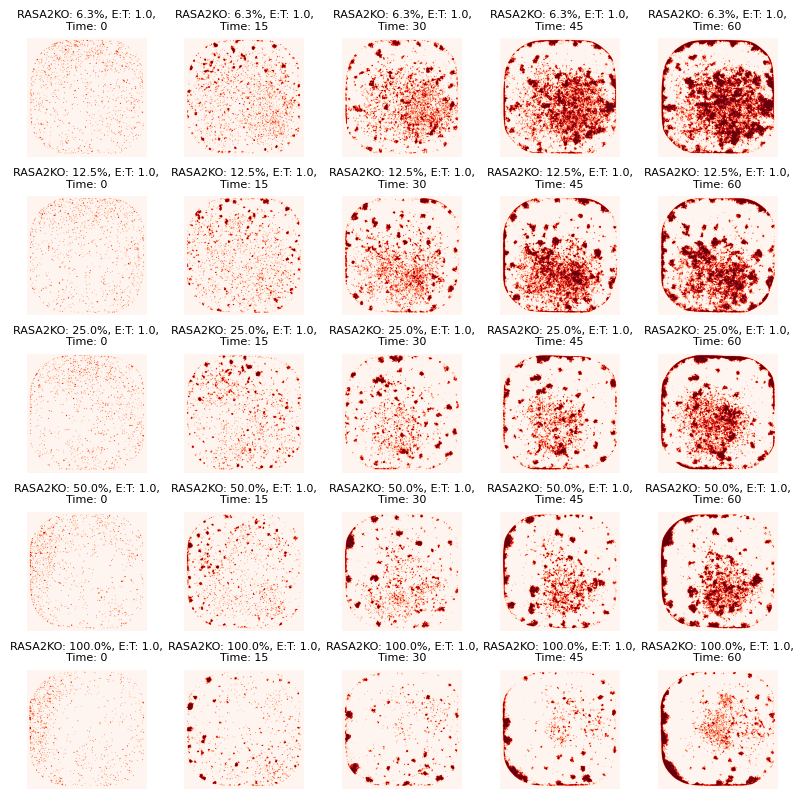

In [19]:
# sweep over RASA2KO titration at a constant E:T ratio
fig, ax = plt.subplots(5, 5, figsize=(8,8), tight_layout=True)

# find 5 evenly spaced time points between 0 and 64
times = [0, 15, 30, 45, 60]
# donor ID is always 1 and replicate ID is always 0
donor_id = 1
replicate_id = 0
# only show the RFP channel
phase=False
# set E:T ratio constant at 1.0
et_value = 1.0

rasa_values = np.sort(entropy_df['rasa2ko_titration'].unique())

for i in range(len(rasa_values)):
    rasa_value = rasa_values[i]
    # top row of subplots have rasa_value=50, et_value=2.0
    for j in range(5):
        plot_representative_fn(entropy_df, rasa_value=rasa_value, et_value=et_value, replicate_id=replicate_id, donor_id=donor_id, time_point=times[j], trim=100, ax=ax[i,j], phase=phase)

plt.show()

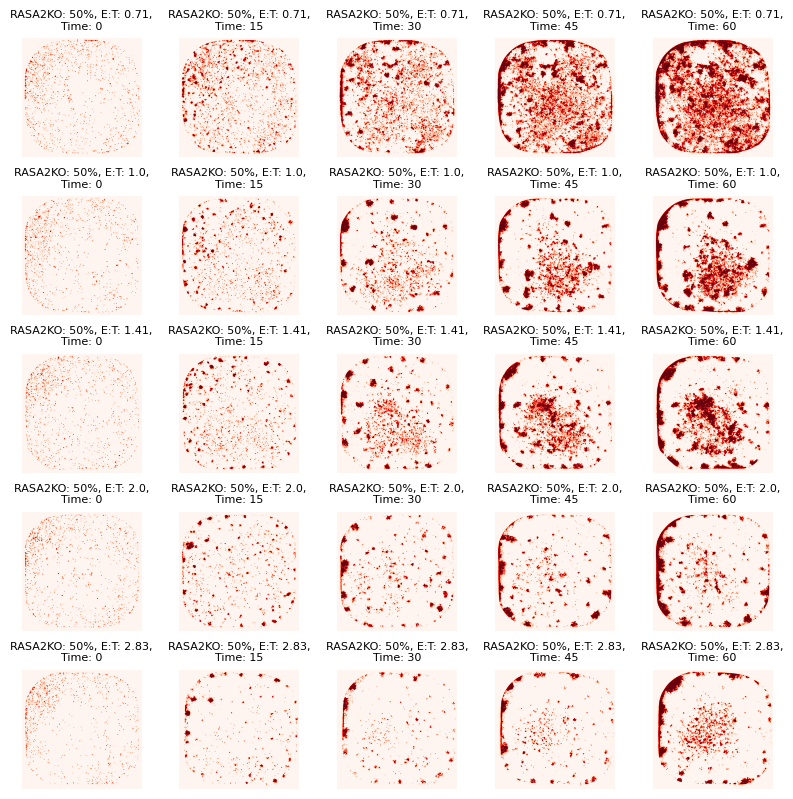

In [20]:
# sweep over E:T ratio at a constant RASA2KO titration
fig, ax = plt.subplots(5, 5, figsize=(8,8), tight_layout=True)

# find 5 evenly spaced time points between 0 and 64
times = [0, 15, 30, 45, 60]
# donor ID is always 1 and replicate ID is always 0
donor_id = 1
replicate_id = 0
# only show the RFP channel
phase = False
# set RASA2KO titration constant at 50
rasa_value = 50

et_values = np.sort(entropy_df['et_ratio'].unique())

for i in range(len(et_values)):
    et_value = et_values[i]
    for j in range(5):
        plot_representative_fn(entropy_df, rasa_value=rasa_value, et_value=et_value, replicate_id=replicate_id, donor_id=donor_id, time_point=times[j], trim=100, ax=ax[i,j], phase=phase)

plt.show()

### Use general linear model to regress entropy against all the covariates

In [21]:
def coef_plot(model, ax=None):
    lin_reg = model
    err_series = lin_reg.params - lin_reg.conf_int()[0]
    err_series
    coef_df = pd.DataFrame({'coef': lin_reg.params.values[1:-1],
                            'err': err_series.values[1:-1],
                            'varname': err_series.index.values[1:-1],
                            'pvalue': lin_reg.pvalues.values[1:-1]
                           })
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    
    # do Bonferroni correction
    coef_df['pvalue'] = coef_df['pvalue'] * len(coef_df)
    
    coef_df.plot(x='varname', y='coef', kind='bar', 
                 ax=ax, color='none', 
                 yerr='err', legend=False)
    ax.set_ylabel('Coefficient (mean +/- std err)')
    ax.set_xlabel('MixedLM term')
    ax.scatter(x=np.arange(coef_df.shape[0]), 
               marker='s', s=20, 
               y=coef_df['coef'], color='black')
    ax.axhline(y=0, linestyle='--', color='grey', linewidth=1)
    # ax.xaxis.set_ticks_position('none')

    # annotate p-values in scientific notation
    for i, pval in enumerate(coef_df['pvalue']):
        if pval > 0.05:
            continue
        elif pval > 0.01:
            ax.text(i, coef_df['coef'].max() + 0.005, 'p={:.1e}'.format(pval), va='bottom', ha='center', rotation=90, color='k')
        elif pval > 0.001:
            ax.text(i, coef_df['coef'].max() + 0.005, 'p={:.1e}'.format(pval), va='bottom', ha='center', rotation=90, color='orange')
        else:
            ax.text(i, coef_df['coef'].max() + 0.005, 'p={:.1e}'.format(pval), va='bottom', ha='center', rotation=90, color='red')
    
    sns.despine(ax=ax, trim=True)
    

def r2(x, y, degree):
    results = {}

    coeffs = np.polyfit(x, y, degree)
     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()

    correlation = np.corrcoef(x, y)[0,1]

     # r
    results['correlation'] = correlation
     # r-squared
    results['determination'] = correlation**2

    return results

/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       entropy  
No. Observations:         13446         Method:                   ML       
No. Groups:               4             Scale:                    0.0204   
Min. group size:          3304          Log-Likelihood:           7062.6310
Max. group size:          3400          Converged:                Yes      
Mean group size:          3361.5                                           
---------------------------------------------------------------------------
                                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        4.564    0.032 143.553 0.000  4.502  4.626
C(replicate)[T.1]               -0.007    0.017  -0.415 0.678 -0.041  0.027
RASA2                           -0.001    0.000  -4.256 0.000 -0.001 -0.001
RASA2:C(replicate)[T.1]        

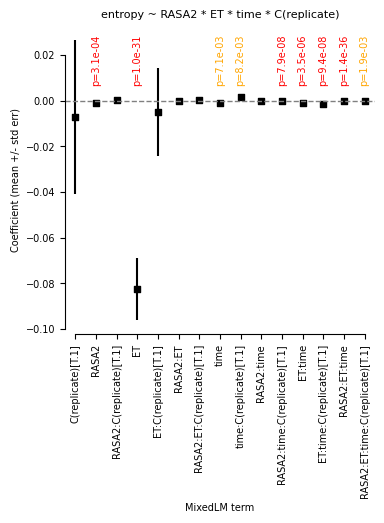

In [22]:
temp_df = entropy_df.rename(columns={'rasa2ko_titration': 'RASA2', 'et_ratio': 'ET', 'replicate_id': 'replicate', 'donor_id': 'donor', 'p_areas': 'RFP_area', 'n_og_keypoints': 'n_keypoints'})

formula = "entropy ~ RASA2 * ET * time * C(replicate)"
mdf1 = smf.mixedlm(formula,
                 temp_df,
                 groups=temp_df["donor"],
                 )
mdf1 = mdf1.fit(reml=False)
print(mdf1.summary())
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
coef_plot(mdf1, ax=ax)
ax.set_title(formula)
plt.show()


/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


                          Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          RFP_area       
No. Observations:            13446            Method:                      ML             
No. Groups:                  4                Scale:                       2609194480.4813
Min. group size:             3304             Log-Likelihood:              -164861.9334   
Max. group size:             3400             Converged:                   Yes            
Mean group size:             3361.5                                                       
------------------------------------------------------------------------------------------
                                    Coef.      Std.Err.    z    P>|z|   [0.025     0.975] 
------------------------------------------------------------------------------------------
Intercept                           22577.944 11473.154   1.968 0.049     90.977 45064.912
C(replicate)[T.1]         

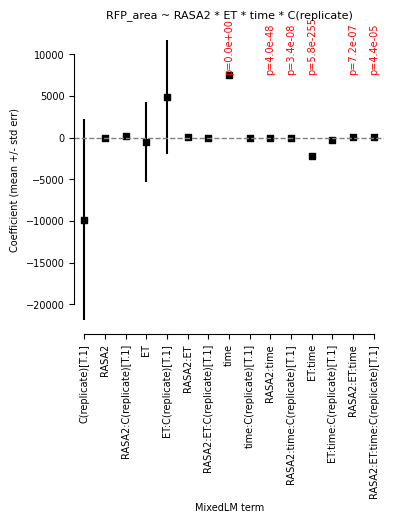

In [23]:
formula = "RFP_area ~ RASA2 * ET * time * C(replicate)"
mdf2 = smf.mixedlm(formula,
                 temp_df,
                 groups=temp_df["donor"],
                 )
mdf2 = mdf2.fit(reml=False)
print(mdf2.summary())
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
coef_plot(mdf2, ax=ax)
ax.set_title(formula)
plt.show()

/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


                      Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         n_keypoints 
No. Observations:         13446           Method:                     ML          
No. Groups:               4               Scale:                      927715.1759 
Min. group size:          3304            Log-Likelihood:             -111468.0549
Max. group size:          3400            Converged:                  Yes         
Mean group size:          3361.5                                                  
----------------------------------------------------------------------------------
                                  Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
----------------------------------------------------------------------------------
Intercept                        2145.556  176.993  12.122 0.000 1798.656 2492.457
C(replicate)[T.1]                -556.619  115.807  -4.806 0.000 -783.596 -329.642
RASA2                      

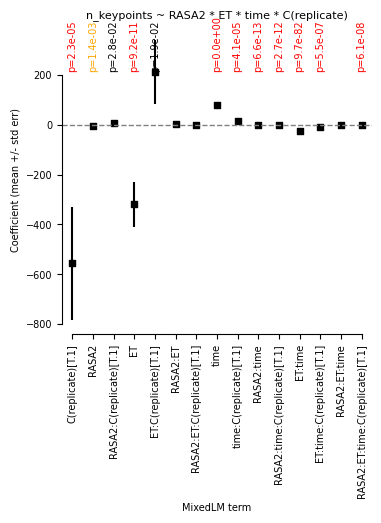

In [24]:

formula = "n_keypoints ~ RASA2 * ET * time * C(replicate)"
mdf3 = smf.mixedlm(formula,
                 temp_df,
                 groups=temp_df["donor"],
                 )
mdf3 = mdf3.fit(reml=False)
print(mdf3.summary())
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
coef_plot(mdf3, ax=ax)
ax.set_title(formula)
plt.show()

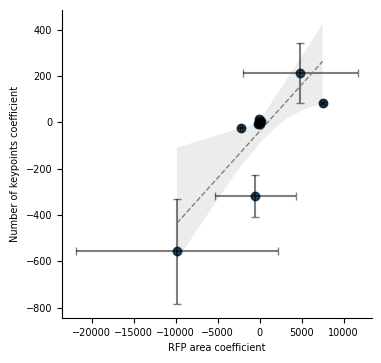

In [25]:
# create a scatter plot of the coefficients for each term in mdf2 (RFP area as target variable) vs mdf3 (number of keypoints as target variable)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
coeffs2 = mdf2.params.values[1:-1]
errs2 = coeffs2 - mdf2.conf_int()[0][1:-1]
coeffs3 = mdf3.params.values[1:-1]
errs3 = coeffs3 - mdf3.conf_int()[0][1:-1]
# sns.scatterplot(x=coeffs2, y=coeffs3, ax=ax)
ax.errorbar(x=coeffs2, y=coeffs3, xerr=errs2, yerr=errs3, capsize=3, color='black', fmt='o', alpha=0.5)
# annotate with seaborn line of best fit
sns.regplot(x=coeffs2, y=coeffs3, ax=ax, line_kws={'color': 'grey', 'lw': 1, 'ls': '--'})
ax.set_xlabel('RFP area coefficient')
ax.set_ylabel('Number of keypoints coefficient')
sns.despine(ax=ax)
plt.show()

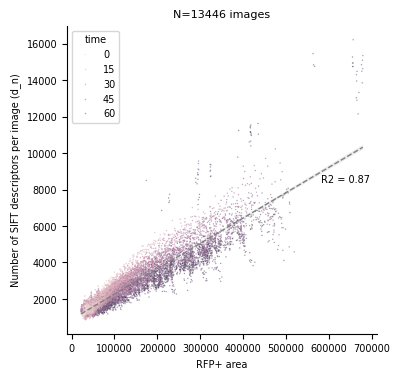

In [35]:
# make a scatterplot of the number of keypoints vs RFP area with the hue being time
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.scatterplot(ax=ax, data=entropy_df, x='p_areas', y='n_og_keypoints', hue='time', s=1, alpha=0.5)
# annotate with seaborn line of best fit
sns.regplot(ax=ax, data=entropy_df, x='p_areas', y='n_og_keypoints', line_kws={'color': 'grey', 'lw': 1, 'ls': '--'}, scatter=False)
# annotate with the R2 value
ax.text(x=0.9, y=0.5, s=f"R2 = {r2(entropy_df['p_areas'], entropy_df['n_og_keypoints'], 2)['determination']:.2f}", transform=ax.transAxes, ha='center', va='center')
ax.set_xlabel('RFP+ area')
ax.set_ylabel('Number of SIFT descriptors per image (d_n)')
ax.set_title('N={} images'.format(len(entropy_df)))
sns.despine(ax=ax)
plt.show()